# Importing Libraries

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler, TimeSeriesScalerMinMax


# Loading Data

In [2]:
merged_data = pd.read_csv(fr'C:\Users\ivane\Desktop\Dissertation\data\merged_data.csv', index_col=0)
merged_data.head()

,Open,Close,Change,sentiment,sentiment_score
Date,,,,,
2025-01-10,3761.549,3736.886,-0.66,0,0.700804
2024-12-19,3780.106,3708.531,-1.93,0,0.950467
2024-12-18,3774.744,3781.551,0.18,1,0.460880
2024-12-16,3748.220,3765.163,0.45,1,0.771217
2024-12-12,3744.519,3748.267,0.10,1,0.927686


# CNN Model

In [3]:
class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(in_channels=5,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv1d(in_channels=hidden_units,
                     out_channels=hidden_units*2,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_units*2),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Calculate the size of flattened features
        # After two MaxPool2d layers with kernel_size=2, the sequence length is divided by 4
        flattened_size = (input_shape // 4) * (hidden_units * 2)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, output_shape)
        )
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [4]:
merged_data.shape

(430, 5)

Epoch [10/250], Loss: 0.0096
Epoch [20/250], Loss: 0.0088
Epoch [30/250], Loss: 0.0058
Epoch [40/250], Loss: 0.0052
Epoch [50/250], Loss: 0.0054
Epoch [60/250], Loss: 0.0049
Epoch [70/250], Loss: 0.0021
Epoch [80/250], Loss: 0.0022
Epoch [90/250], Loss: 0.0027
Epoch [100/250], Loss: 0.0020
Epoch [110/250], Loss: 0.0014
Epoch [120/250], Loss: 0.0013
Epoch [130/250], Loss: 0.0015
Epoch [140/250], Loss: 0.0013
Epoch [150/250], Loss: 0.0009
Epoch [160/250], Loss: 0.0017
Epoch [170/250], Loss: 0.0010
Epoch [180/250], Loss: 0.0011
Epoch [190/250], Loss: 0.0010
Epoch [200/250], Loss: 0.0012
Epoch [210/250], Loss: 0.0014
Epoch [220/250], Loss: 0.0007
Epoch [230/250], Loss: 0.0011
Epoch [240/250], Loss: 0.0007
Epoch [250/250], Loss: 0.0008
Mean Squared Error: 2408.46
R2 Score: 0.73


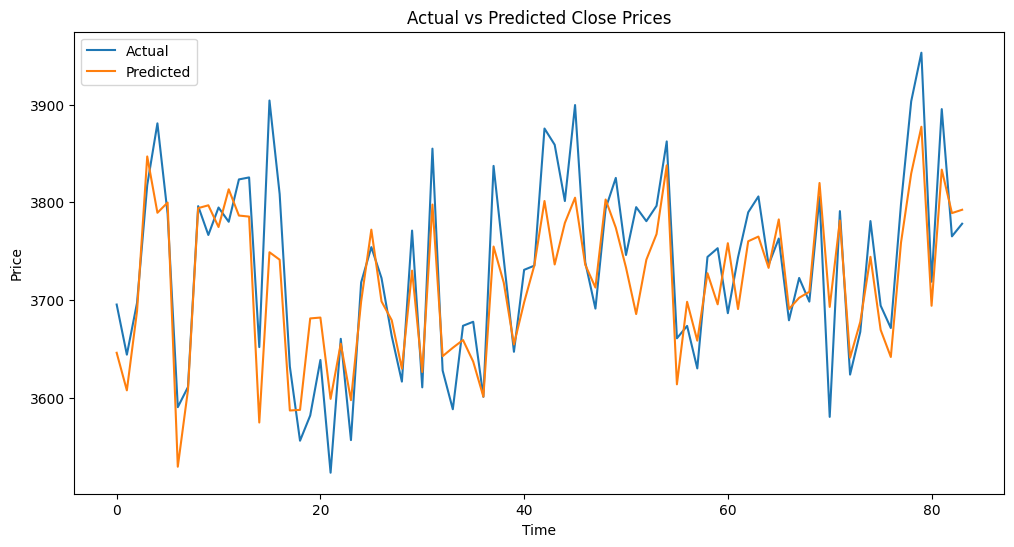

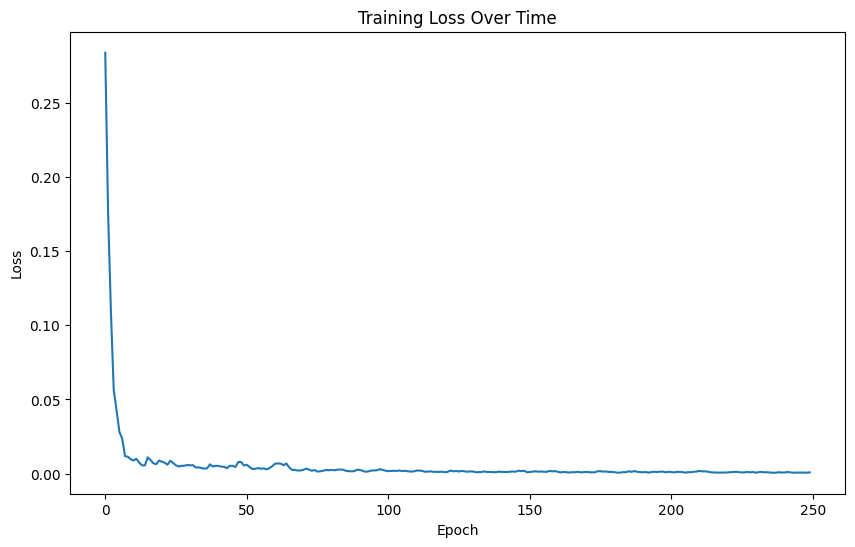

In [5]:
# 1. Data Preprocessing
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data)
scaled_data = scaled_data.astype(np.float32)  # Convert to float32 for PyTorch

# Create sequences (assuming we want to predict next day's Close price)
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 1])  # Index 1 for Close price
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(scaled_data)

# Reshape X to match CNN input shape (batch_size, channels, sequence_length)
X = np.transpose(X, (0, 2, 1))  # Reshape to (samples, features, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Create data loaders
batch_size = 40
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=batch_size)

# 2. Initialize model, loss function, and optimizer
input_shape = seq_length
hidden_units = 64
output_shape = 1  # Predicting single value (Close price)

model = CNN(input_shape=input_shape, hidden_units=hidden_units, output_shape=output_shape)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.001)

# 3. Training loop
num_epochs = 250
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# 4. Evaluation
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(y_batch.tolist())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)

predictions_rescaled = scaler.inverse_transform(np.hstack([np.zeros((len(predictions), 1)), predictions, np.zeros((len(predictions), 3))]))[: , 1]
actuals_rescaled = scaler.inverse_transform(np.hstack([np.zeros((len(actuals), 1)), actuals, np.zeros((len(actuals), 3))]))[: , 1]

# Calculate metrics
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
r2 = r2_score(actuals_rescaled, predictions_rescaled)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')

# 5. Plot results
plt.figure(figsize=(12, 6))
plt.plot(actuals_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# LSTM Model

In [11]:
class CNNLSTM(nn.Module):
    def __init__(self, input_shape: int, cnn_hidden_units: int, lstm_hidden_size: int, lstm_num_layers: int, output_shape: int):
        super().__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_num_layers = lstm_num_layers
        
        # CNN layers (using your existing CNN architecture)
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(in_channels=5,
                     out_channels=cnn_hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_hidden_units),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv1d(in_channels=cnn_hidden_units,
                     out_channels=cnn_hidden_units*2,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(cnn_hidden_units*2),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Calculate CNN output size
        self.cnn_output_size = (input_shape // 4) * (cnn_hidden_units * 2)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True
        )
        
        # Final fully connected layer
        self.fc = nn.Linear(lstm_hidden_size, output_shape)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN forward pass
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        
        # Reshape for LSTM
        # After CNN, shape is [batch_size, channels, seq_length]
        # Need to reshape to [batch_size, seq_length, features] for LSTM
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(batch_size, -1, self.cnn_output_size)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # Use the last output from LSTM
        lstm_out = lstm_out[:, -1, :]
        
        # Final prediction
        output = self.fc(lstm_out)
        
        return output

# Training setup and loop
def train_cnn_lstm(model, train_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(avg_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
    return train_losses

In [12]:
# Example usage:

# Model parameters
input_shape = seq_length
cnn_hidden_units = 64
lstm_hidden_size = 32
lstm_num_layers = 2
output_shape = 1

# Initialize model
model = CNNLSTM(
    input_shape=input_shape,
    cnn_hidden_units=cnn_hidden_units,
    lstm_hidden_size=lstm_hidden_size,
    lstm_num_layers=lstm_num_layers,
    output_shape=output_shape
)

# Setup training
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
train_losses = train_cnn_lstm(model, train_loader, criterion, optimizer, num_epochs=250, device=device)

Epoch [10/250], Loss: 0.0026
Epoch [20/250], Loss: 0.0012
Epoch [30/250], Loss: 0.0005
Epoch [40/250], Loss: 0.0004
Epoch [50/250], Loss: 0.0004
Epoch [60/250], Loss: 0.0003
Epoch [70/250], Loss: 0.0001
Epoch [80/250], Loss: 0.0002
Epoch [90/250], Loss: 0.0001
Epoch [100/250], Loss: 0.0003
Epoch [110/250], Loss: 0.0001
Epoch [120/250], Loss: 0.0001
Epoch [130/250], Loss: 0.0001
Epoch [140/250], Loss: 0.0001
Epoch [150/250], Loss: 0.0001
Epoch [160/250], Loss: 0.0003
Epoch [170/250], Loss: 0.0001
Epoch [180/250], Loss: 0.0001
Epoch [190/250], Loss: 0.0001
Epoch [200/250], Loss: 0.0001
Epoch [210/250], Loss: 0.0001
Epoch [220/250], Loss: 0.0001
Epoch [230/250], Loss: 0.0000
Epoch [240/250], Loss: 0.0001
Epoch [250/250], Loss: 0.0000


In [14]:
from sklearn.metrics import mean_absolute_error

Mean Squared Error: 1139.14
Root Mean Squared Error: 33.75
Mean Absolute Error: 26.70
R2 Score: 0.87


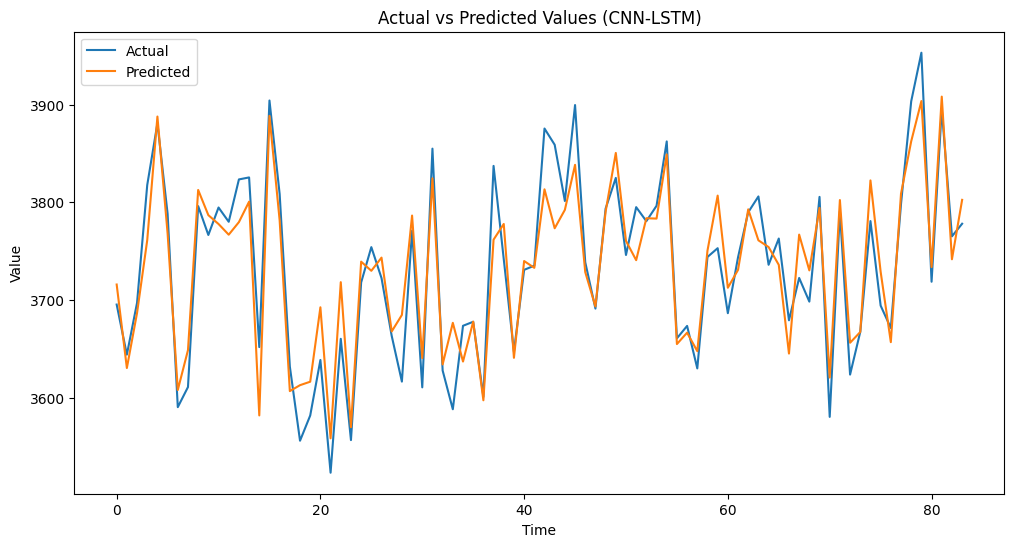

In [15]:
# Add evaluation code
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().squeeze().tolist())
        actuals.extend(y_batch.tolist())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
actuals = np.array(actuals).reshape(-1, 1)
predictions_rescaled = scaler.inverse_transform(np.hstack([np.zeros((len(predictions), 1)), predictions, np.zeros((len(predictions), 3))]))[: , 1]
actuals_rescaled = scaler.inverse_transform(np.hstack([np.zeros((len(actuals), 1)), actuals, np.zeros((len(actuals), 3))]))[: , 1]

# Calculate metrics
mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
r2 = r2_score(actuals_rescaled, predictions_rescaled)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R2 Score: {r2:.2f}')

# Visualize results
plt.figure(figsize=(12, 6))
plt.plot(actuals_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Predicted')
plt.title('Actual vs Predicted Values (CNN-LSTM)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()